In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict): # => Inheriting TypeDict
    """
    TypedDict: This is like a typed dictionary from Python's typing module. It defines the structure of your state with type hints.

    State: This is the main state container that flows through your graph. It's a dictionary with specific keys and types.

    messages: A key in the State dictionary that holds conversation messages.

    """

    messages:Annotated[list,add_messages]
    """
    Annotated[Type, ...]: A way to add metadata/annotations to a type hint.

    First argument (list): The actual type of the data (a list of messages).

    Second argument (add_messages): A function that defines HOW this state key should be updated when new values come in.

    """
    """
    Without Annotated, when you return {"messages": new_message} from a node, it would overwrite the entire messages list.

    With Annotated[list, add_messages]:

    When you return {"messages": new_message} from a node

    add_messages function appends the new message to the existing list

    This maintains conversation history automatically!
    
    """

    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# 1) Initialize model
from langchain_ollama import OllamaLLM

llm = OllamaLLM(model="llama3.2:latest")

In [5]:
llm

OllamaLLM(model='llama3.2:latest')

In [6]:
# Another way to initialize model
from langchain.chat_models import init_chat_model

llm = init_chat_model(model="llama3.2:latest", model_provider="ollama")

In [7]:
llm

ChatOllama(model='llama3.2:latest')

In [8]:
# 2) Creating Node defination (Node functionality)
def chatbot(state:State): # => Inheriting State  
    return {"messages":[llm.invoke(state["messages"])]}

In [9]:
# Regular Class Approach:

# class StateClass:
#     def __init__(self):
#         self.messages = []
        
# state = StateClass()
# print(state.messages)  # ✅ Access with dot notation
# state.messages.append("hello")  # ✅ Modify directly

In [10]:
# TypedDict Approach (What LangGraph uses):
# from typing import TypedDict

# class State(TypedDict):
#     messages: list
    
# # Actually using dictionaries
# state: State = {"messages": []}  # Plain dict!
# print(state["messages"])  # ✅ Dictionary access
# state["messages"].append("hello")  # ✅ Dictionary modification

In [11]:
# The above code broken down:
# def chatbot(state: State):  # Type hint says "this dict should have this structure"
#     # state IS A DICTIONARY
#     print(type(state))  # <class 'dict'>
    
#     # Access like a dictionary
#     messages_list = state["messages"]  # Get the list
    
#     # Process with LLM
#     response = llm.invoke(messages_list)
    
#     # Return a dictionary (partial state update)
#     return {"messages": [response]}
    
#     # LangGraph's add_messages will handle the merging:
#     # Old state: {"messages": [existing_messages]}
#     # Returned: {"messages": [new_response]}
#     # Result: {"messages": [existing_messages, new_response]}

In [12]:
# 3) Graph builder
graph_builder = StateGraph(State)
"""
Creates a graph that operates on State objects. Every node in this graph will receive and return State dictionaries.
"""
# Add the node to the graph
graph_builder.add_node("chatbot", chatbot)

# Set entry point
graph_builder.set_entry_point("chatbot")

# Add edges (how the graph flows)
graph_builder.add_edge("chatbot", END)  # Or to another node

# Compile the graph
graph = graph_builder.compile()
# graph

In [13]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))
except Exception as e:
    print(e)

Failed to reach https://mermaid.ink API while trying to render your graph. Status code: 400.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`


In [14]:
# Add this to test if the graph works (in basicchatbot notebook)
from langchain_core.messages import HumanMessage

# Test execution
initial_state = {"messages": [HumanMessage(content="Hello!")]}
result = graph.invoke(initial_state)
print("Graph execution successful!")
print(f"Response: {result['messages'][-1].content}")

Graph execution successful!
Response: Hello! How can I assist you today?


In [15]:
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	chatbot(chatbot)
	__end__([<p>__end__</p>]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [16]:
# # Get and display the Mermaid code
# graph = graph_builder.compile()
# mermaid_code = graph.get_graph().draw_mermaid()

# print("Mermaid Diagram Code:")
# print("-" * 50)
# print(mermaid_code)
# print("-" * 50)

# # Save to file
# with open("chatbot_graph.mmd", "w") as f:
#     f.write(mermaid_code)
# print("✓ Saved to chatbot_graph.mmd")

# # Display in Jupyter
# from IPython.display import HTML, display

# html = f"""
# <div class="mermaid">
# {mermaid_code}
# </div>
# <script src="https://cdn.jsdelivr.net/npm/mermaid/dist/mermaid.min.js"></script>
# <script>mermaid.initialize({{startOnLoad:true}});</script>
# """

# display(HTML(html))
# print("✓ Diagram displayed above")

In [17]:
graph.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
 +---------+   
 | chatbot |   
 +---------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


In [18]:
graph.invoke({"messages":"Hi"})

{'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='7bc77340-e516-41cc-bb55-6d118a7b5b7d'),
  AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T12:29:48.0086658Z', 'done': True, 'done_reason': 'stop', 'total_duration': 779896300, 'load_duration': 154912400, 'prompt_eval_count': 26, 'prompt_eval_duration': 152166500, 'eval_count': 8, 'eval_duration': 457472500, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, id='lc_run--019b4b2f-df5b-7b03-88e1-c5e011ce65bb-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})]}

In [19]:
response = graph.invoke({"messages":"Hi"})

In [20]:
response["messages"] # This is a list of Message objects

[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='c4e9c938-8cca-4c3c-86e4-41dfcdeda66e'),
 AIMessage(content='How can I help you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T12:29:48.7205144Z', 'done': True, 'done_reason': 'stop', 'total_duration': 695022700, 'load_duration': 135095400, 'prompt_eval_count': 26, 'prompt_eval_duration': 62885000, 'eval_count': 8, 'eval_duration': 483879700, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, id='lc_run--019b4b2f-e278-7fb0-98b1-ca86be4c97c5-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})]

In [21]:
response["messages"][-1] # This is an AIMessage object

AIMessage(content='How can I help you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T12:29:48.7205144Z', 'done': True, 'done_reason': 'stop', 'total_duration': 695022700, 'load_duration': 135095400, 'prompt_eval_count': 26, 'prompt_eval_duration': 62885000, 'eval_count': 8, 'eval_duration': 483879700, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, id='lc_run--019b4b2f-e278-7fb0-98b1-ca86be4c97c5-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})

In [22]:
response["messages"][-1].content

'How can I help you today?'

In [23]:
for event in graph.stream({"messages":"Hi"}):
    print(event)

{'chatbot': {'messages': [AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T12:29:49.5477343Z', 'done': True, 'done_reason': 'stop', 'total_duration': 756099200, 'load_duration': 193483300, 'prompt_eval_count': 26, 'prompt_eval_duration': 72043300, 'eval_count': 8, 'eval_duration': 479628100, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, id='lc_run--019b4b2f-e573-7b50-b8dd-092b7cd6e569-0', usage_metadata={'input_tokens': 26, 'output_tokens': 8, 'total_tokens': 34})]}}


In [24]:
for event in graph.stream({"messages":"Hi"}):
    # print(event)
    for val in event.values():
        print(val["messages"][0].content)

How can I assist you today?


In [25]:
# response (dict)
#     |   
#     └── "messages" (list)
#             |
#             └── [-1] → AIMessage object
#                         |
#                         ├── .content = "Hello!" (string)
#                         ├── .additional_kwargs = {} (dict)
#                         └── .response_metadata = {} (dict)

## Chat bot with tool

In [26]:
from langchain_tavily import TavilySearch

d:\Studies\Programming\LangChain\venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
d:\Studies\Programming\LangChain\venv\Lib\site-packages\langchain_tavily\tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [27]:
tool = TavilySearch(max_results=2)
# tool.invoke("What is Langchain tools")

In [28]:
## Custom function 
## DocString
def multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [29]:
tools = [tool,multiply]

In [30]:
llm_with_tool = llm.bind_tools(tools)

In [31]:
llm_with_tool

RunnableBinding(bound=ChatOllama(model='llama3.2:latest'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains to restrict search results to.\n\n        Use this parameter when:\n        1. The user explicitly requests information from specific websites (e.g., "Find climate data from nasa.gov")\n        2. The user mentions an organ

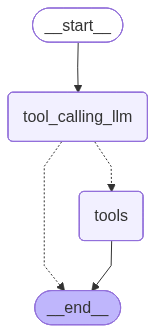

In [32]:
# Creating state graph

from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Creating graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Adding edges

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## Compiling the graph and viweing

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
response = graph.invoke({"messages":["what is the latest ai news"]})

In [34]:
response['messages'][-1].content

'{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.google/technology/ai/google-ai-news-recap-2025/", "title": "60 of our biggest AI announcements in 2025 - Google Blog", "content": "We didn’t let up as we rounded the bend of 2025. Instead, we squeezed even more AI news into an already jam-packed year with the introduction of Gemini 3 Flash, our annual Year in Search release and still more announcements to round us out. Here were some of the top Google AI news stories of the month: [...] August tends to be a big month for hardware at Google, and this year was no exception thanks to our latest Pixel lineup. We also officially unveiled Nano Banana, our viral image editing model from Google DeepMind. Here were some of the top Google AI news stories of the month:\\n\\nAugust_latest AI News\\n\\n## September [...] Our April AI announcements ran the gamut: On the infrastructure side, we unveiled Ironwood, our latest TPU. A

In [35]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the latest ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (0c82d6fc-4414-4011-8121-9ff061c926e3)
 Call ID: 0c82d6fc-4414-4011-8121-9ff061c926e3
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_images: False
    query: latest AI news
    search_depth: advanced
    start_date: None
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.google/technology/ai/google-ai-news-recap-2025/", "title": "60 of our biggest AI announcements in 2025 - Google Blog", "content": "We didn’t let up as we rounded the bend of 2025. Instead, we squeezed even more AI news into an already jam-packed year with the introduction 

In [36]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (0d2407cc-ee94-4433-8ae7-f06c4179f6ce)
 Call ID: 0d2407cc-ee94-4433-8ae7-f06c4179f6ce
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: multiply

10


In [37]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (b063f170-3ec8-495f-9fcc-b2ce768b9e41)
 Call ID: b063f170-3ec8-495f-9fcc-b2ce768b9e41
  Args:
    end_date: 2024-12-31
    query: recent AI news
    start_date: 2024-01-01
    time_range: week
    topic: general
  multiply (4dc70d9a-e870-4a5e-a4d8-11c010fc83d5)
 Call ID: 4dc70d9a-e870-4a5e-a4d8-11c010fc83d5
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{'error': ValueError('Error 400: When time_range is set, start_date or end_date cannot be set')}
================================= Tool Message =================================
Name: multiply

50


## ReAct Agent Architecture

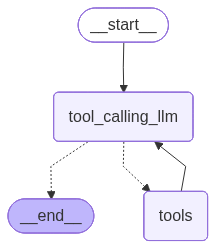

In [38]:
# Creating state graph

from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Creating graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Adding edges

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## Compiling the graph and viweing

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
response=graph.invoke({"messages":["Give me the recent ai news and then multiply 5 by 10"]})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (aedacd9b-0e09-4756-b7d0-e4686fe0f5e6)
 Call ID: aedacd9b-0e09-4756-b7d0-e4686fe0f5e6
  Args:
    end_date: None
    include_images: True
    query: recent AI news
    start_date: 2024-01-01
    time_range: None
    topic: general
  multiply (d0ae994d-7555-4dfa-b228-005f443a499e)
 Call ID: d0ae994d-7555-4dfa-b228-005f443a499e
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": ["https://robots.net/wp-content/uploads/2024/01/the-impact-of-artificial-intelligence-in-2024-1705342707.jpg", "https://bunny-wp-pullzone-zx8kuhooz6.b-cdn.net/wp-content/uploads/2024/07/65981c637e66f490631f4efd_The-A

## Adding Memory In Agentic Graph

In [40]:
response = graph.invoke({"messages":"Hello my name is Rohan"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Rohan
================================== Ai Message ==================================
Tool Calls:
  tavily_search (387b0cc2-f61a-448e-a219-a7df2519739b)
 Call ID: 387b0cc2-f61a-448e-a219-a7df2519739b
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_images: False
    query: 
    search_depth: advanced
    start_date: None
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{'error': ValueError('Error 400: Query is missing.')}
================================== Ai Message ==================================

Hello Rohan! It seems like I didn't receive a question from you yet. Could you please provide me with a question or topic you'd like to know more about? I'll do my best to help!


In [41]:
response = graph.invoke({"messages":"What is my name"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is my name
================================== Ai Message ==================================
Tool Calls:
  tavily_search (e01856c2-49fa-43c5-a54e-31b0f9b0a81c)
 Call ID: e01856c2-49fa-43c5-a54e-31b0f9b0a81c
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_images: False
    query: what is my name
    search_depth: basic
    start_date: None
    time_range: None
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "what is my name", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/What%27s_My_Name%3F", "title": "What's My Name? - Wikipedia", "content": "**What's My Name?** or **What's My Name** may refer to:. * \"What's My Name?\" (Rihanna song) \"What's My Name? * \"What's My Name\" (Descendants song) \"What's My Name (Desce

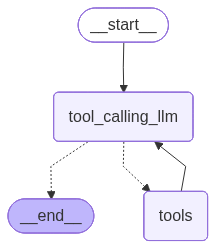

In [42]:
# Creating state graph

from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver 

## To remember the chat
memory = MemorySaver()

## Node defination

def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Creating graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Adding edges

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## Compiling the graph and viweing

graph = builder.compile(checkpointer=memory) ## to keep track of memory

display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":["Hi my name is Rohan"]},config=config)

response

{'messages': [HumanMessage(content='Hi my name is Rohan', additional_kwargs={}, response_metadata={}, id='3629bf6f-2eaf-41d0-b29c-7953daf154ba'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T12:31:41.9316742Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13261828700, 'load_duration': 139306500, 'prompt_eval_count': 1415, 'prompt_eval_duration': 7772474800, 'eval_count': 74, 'eval_duration': 5260564500, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, id='lc_run--019b4b31-6b9c-7a22-98cc-73fb59870128-0', tool_calls=[{'name': 'tavily_search', 'args': {'end_date': None, 'exclude_domains': None, 'include_domains': None, 'include_images': False, 'query': 'introduction to tavily_search tool', 'search_depth': 'advanced', 'start_date': None, 'time_range': None, 'topic': 'general'}, 'id': '7bfdcd87-f20a-4db3-904a-cb0bc04a536e', 'type': 'tool_call'}], usage_metadata={'input_tokens':

In [44]:
response['messages'][-1].content

"Hello Rohan! \n\nI'd be happy to help you with your question about Tavily_search tool. From the search results, it seems that Tavily_search is an AI-powered search API designed specifically for LLM applications. It provides reliable, real-time information retrieval capabilities with features optimized for AI use cases.\n\nWith Tavily_search, you can perform AI-powered web searches and extract content from specific URLs. The tool requires an API Key for integration into your workflow.\n\nHere are some key points to get you started with Tavily_search:\n\n*   Integrate Tavily into your workflow to search the web and extract information.\n*   Search the web and extract content from specific URLs using the `tavily_search` tool.\n*   Requires API Key for integration.\n\nIf you have any more questions or need further clarification, feel free to ask!"

In [45]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

Your name is Rohan! According to the search results, a user can be defined as someone who employs or uses a particular thing, like a user of nicotine or a user of an internet site. You are currently using Vocabulary.com to learn more about different topics!


## Streaming

In [46]:
# https://docs.langchain.com/oss/python/langchain/streaming
# LangChain implements a streaming system to surface real-time updates.
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [47]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

In [48]:
graph = StateGraph(State)

## node 
graph.add_node("SuperBot",superbot)

## Edges
graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)

graph_builder = graph.compile(checkpointer=memory)

## Display
# display(Image(graph_builder.get_graph().draw_mermaid_png()))
graph_builder.get_graph().print_ascii()

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
+----------+   
| SuperBot |   
+----------+   
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   


In [49]:
print(graph_builder.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	SuperBot(SuperBot)
	__end__([<p>__end__</p>]):::last
	__start__ --> SuperBot;
	SuperBot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [50]:
## Invocation

config = {"configurable": {"thread_id": "1"}}

graph_builder.invoke({'messages':"Hi,My name is Rohan And I like playing Valorant"},config)

{'messages': [HumanMessage(content='Hi,My name is Rohan And I like playing Valorant', additional_kwargs={}, response_metadata={}, id='aa0b9b99-29f1-45c3-bfb7-6dae069f20bd'),
  AIMessage(content="Hello Rohan! Nice to meet you. Valorant is a popular multiplayer first-person shooter game developed by Riot Games. It requires strategy, teamwork, and quick reflexes.\n\nWhich role do you prefer playing in Valorant? Are you more of an Attacker, Defensor, or Sentinel player?\n\nAlso, what's your favorite agent to play as?", additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T12:32:27.9546709Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5379761800, 'load_duration': 156019000, 'prompt_eval_count': 38, 'prompt_eval_duration': 426041400, 'eval_count': 72, 'eval_duration': 4679441000, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, id='lc_run--019b4b32-3e2d-76d2-b4b5-a6cae3ce6d06-0', usage_metadata={'input_tokens

## Streaming
Methods: .stream() and astream()

These methods are sync and async methods for streaming back results.
Additional parameters in streaming modes for graph state

1) values : This streams the full state of the graph after each node is called.
2) updates : This streams updates to the state of the graph after each node is called.

In [51]:
# Create a thread
# When you use stream_mode="updates", you see all state changes in real-time
# Best for Debugging, seeing the flow step-by-step
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Rohan And I like playing Valorant"},config,stream_mode="updates"):
    print(chunk)
    """
    This will output:
    First chunk: The initial state with your human message
    Second chunk: The updated state with the AI's response added
    """

{'SuperBot': {'messages': [AIMessage(content="Hello Rohan! Nice to meet you! Valorant is a popular tactical first-person shooter game, and it's great that you enjoy playing it!\n\nAre you part of an active team or do you play casually? What's your role in the game - is it Duelist, Sentinel, or maybe Initiator?\n\nLet's chat more about Valorant!", additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T12:32:33.6304588Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5655418700, 'load_duration': 159391300, 'prompt_eval_count': 38, 'prompt_eval_duration': 72761000, 'eval_count': 72, 'eval_duration': 5311742700, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, id='lc_run--019b4b32-5346-72b0-9a6b-9716097c6a5e-0', usage_metadata={'input_tokens': 38, 'output_tokens': 72, 'total_tokens': 110})]}}


In [52]:
# Create a thread
# This gives you only the final values after each node completes:
# Best for: Monitoring node outputs
for chunk in graph_builder.stream({'messages':"Hi,My name is Rohan And I like playing Valorant"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Rohan And I like playing Valorant', additional_kwargs={}, response_metadata={}, id='fdce2f00-ec50-484a-8f6c-79103930f793'), AIMessage(content="Hello Rohan! Nice to meet you! Valorant is a popular tactical first-person shooter game, and it's great that you enjoy playing it!\n\nAre you part of an active team or do you play casually? What's your role in the game - is it Duelist, Sentinel, or maybe Initiator?\n\nLet's chat more about Valorant!", additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T12:32:33.6304588Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5655418700, 'load_duration': 159391300, 'prompt_eval_count': 38, 'prompt_eval_duration': 72761000, 'eval_count': 72, 'eval_duration': 5311742700, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, id='lc_run--019b4b32-5346-72b0-9a6b-9716097c6a5e-0', usage_metadata={'input_tokens': 38, 'output_tokens': 72

In [53]:
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is Rohan And I like playing Valorant"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hello Rohan! Nice to meet you. Valorant is a popular tactical first-person shooter game that requires strategy and skill to play well.\n\nWhat's your role in Valorant? Are you a Duelist, Sentinel, or Initiator? Do you have a favorite agent or playstyle?\n\nAre you looking for tips or strategies to improve your gameplay? Or maybe you'd like to discuss the latest patch notes or upcoming updates in the game?", additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T12:32:47.7376388Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6966120400, 'load_duration': 199193500, 'prompt_eval_count': 38, 'prompt_eval_duration': 80678000, 'eval_count': 89, 'eval_duration': 6541070700, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, id='lc_run--019b4b32-8542-7d11-aaeb-da872c20cacc-0', usage_metadata={'input_tokens': 38, 'output_tokens': 89, 'total_tokens': 127})]}}


In [54]:
for chunk in graph_builder.stream({'messages':"Hi,My name is Rohan And I also like playing clash of clans"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is Rohan And I like playing Valorant', additional_kwargs={}, response_metadata={}, id='480594eb-0adf-4c27-9911-de53035669a6'), AIMessage(content="Hello Rohan! Nice to meet you. Valorant is a popular tactical first-person shooter game that requires strategy and skill to play well.\n\nWhat's your role in Valorant? Are you a Duelist, Sentinel, or Initiator? Do you have a favorite agent or playstyle?\n\nAre you looking for tips or strategies to improve your gameplay? Or maybe you'd like to discuss the latest patch notes or upcoming updates in the game?", additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-12-23T12:32:47.7376388Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6966120400, 'load_duration': 199193500, 'prompt_eval_count': 38, 'prompt_eval_duration': 80678000, 'eval_count': 89, 'eval_duration': 6541070700, 'logprobs': None, 'model_name': 'llama3.2:latest', 'model_provider': 'ollama'}, 

## Human in the loop

In [55]:
# Another way to initialize model
from langchain.chat_models import init_chat_model

llm = init_chat_model(model="llama3.2:latest", model_provider="ollama")

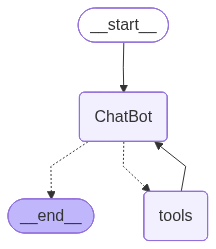

In [61]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from IPython.display import Image  # Added import

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request Assistant from human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

search_tool = TavilySearch(max_results=2)  

# Tool binding
tools = [search_tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)  

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])  
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume
    return {"messages": [message]}

graph_builder.add_node("ChatBot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "ChatBot",  
    tools_condition,
)

graph_builder.add_edge(START, "ChatBot")
graph_builder.add_edge("tools", "ChatBot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (b699401e-77bf-42a4-870e-2ffe5f76743b)
 Call ID: b699401e-77bf-42a4-870e-2ffe5f76743b
  Args:
    query: expert guidance and assistance for building an AI agent
================================== Ai Message ==================================
Tool Calls:
  human_assistance (b699401e-77bf-42a4-870e-2ffe5f76743b)
 Call ID: b699401e-77bf-42a4-870e-2ffe5f76743b
  Args:
    query: expert guidance and assistance for building an AI agent


In [63]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (b699401e-77bf-42a4-870e-2ffe5f76743b)
 Call ID: b699401e-77bf-42a4-870e-2ffe5f76743b
  Args:
    query: expert guidance and assistance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

It seems like you're looking for a way to build an AI agent that can interact with its environment in a more sophisticated manner. LangGraph is a great choice because it allows you to create more complex behaviors and decision-making processes.

Here are some steps you can follow to get started:

1. **Define your goals**: What do you want your AI agent to achieve? Is it for